In [5]:
import boto3
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import precision_recall_cutoff as prc
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report


# Defining the s3 bucket
s3 = boto3.resource('s3')
bucket_name = 'data-445-wagner'
bucket = s3.Bucket(bucket_name)

# Defining the file to be read from s3 bucket
file_key = "train.csv"

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# Reading the csv file
train = pd.read_csv(file_content_stream, sep = '|')

# Defining the file to be read from s3 bucket
file_key1 = "test.csv"

bucket_object1 = bucket.Object(file_key1)
file_object1 = bucket_object1.get()
file_content_stream1 = file_object1.get('Body')

# Reading the csv file
test = pd.read_csv(file_content_stream1, sep = '|')
test.head()

,trustLevel,totalScanTimeInSeconds,grandTotal,lineItemVoids,scansWithoutRegistration,quantityModifications,scannedLineItemsPerSecond,valuePerSecond,lineItemVoidsPerPosition
0,4,467,88.48,4,8,4,0.014989,0.189465,0.571429
1,3,1004,58.99,7,6,1,0.026892,0.058755,0.259259
2,1,162,14.00,4,5,4,0.006173,0.086420,4.000000
3,5,532,84.79,9,3,4,0.026316,0.159380,0.642857
4,5,890,42.16,4,0,0,0.021348,0.047371,0.210526


In [6]:
#Creating interactions and features from past assignments for train dataset
train['Interaction_1'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] <= 0.012) & (train['lineItemVoids'] <= 10.5), 1, 0)
train['Interaction_2'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] <= 0.012) & (train['lineItemVoids'] >= 10.5), 1, 0)
train['Interaction_3'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] >= 0.012) & (train['totalScanTimeInSeconds'] <= 895.0), 1, 0)
train['Interaction_4'] = np.where((train['trustLevel'] <= 1.5) & (train['scannedLineItemsPerSecond'] >= 0.012) & (train['totalScanTimeInSeconds'] >= 895.0), 1, 0)
train['Interaction_5'] = np.where((train['trustLevel'] >= 1.5) & (train['trustLevel'] <= 2.5) & (train['totalScanTimeInSeconds'] <= 1298.0), 1, 0)
train['Interaction_6'] = np.where((train['trustLevel'] >= 1.5) & (train['trustLevel'] <= 2.5) & (train['totalScanTimeInSeconds'] >= 1298.0), 1, 0)
train['Interaction_7'] = np.where((train['trustLevel'] >= 1.5) & (train['trustLevel'] >= 2.5), 1, 0)
train['newInteraction_1'] = np.where((train['Interaction_4'] <= 0.5) & (train['Interaction_3'] <= 0.5) & (train['Interaction_6'] <= 0.5), 1, 0)
train['newInteraction_2'] = np.where((train['Interaction_4'] <= 0.5) & (train['Interaction_3'] <= 0.5) & (train['Interaction_6'] >= 0.5), 1, 0)
train['newInteraction_3'] = np.where((train['Interaction_4'] <= 0.5) & (train['Interaction_3'] >= 0.5) & (train['lineItemVoidsPerPosition'] <= 0.429), 1, 0)
train['feature1'] = train['Interaction_4'] * train['trustLevel']
train['feature2'] = train['Interaction_4'] * train['Interaction_7']
train['feature3'] = train['trustLevel'] * train['Interaction_7']

In [7]:
#creating variables from past assignments for the test dataset
test['Interaction_1'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] <= 0.012) & (test['lineItemVoids'] <= 10.5), 1, 0)
test['Interaction_2'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] <= 0.012) & (test['lineItemVoids'] >= 10.5), 1, 0)
test['Interaction_3'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] >= 0.012) & (test['totalScanTimeInSeconds'] <= 895.0), 1, 0)
test['Interaction_4'] = np.where((test['trustLevel'] <= 1.5) & (test['scannedLineItemsPerSecond'] >= 0.012) & (test['totalScanTimeInSeconds'] >= 895.0), 1, 0)
test['Interaction_5'] = np.where((test['trustLevel'] >= 1.5) & (test['trustLevel'] <= 2.5) & (test['totalScanTimeInSeconds'] <= 1298.0), 1, 0)
test['Interaction_6'] = np.where((test['trustLevel'] >= 1.5) & (test['trustLevel'] <= 2.5) & (test['totalScanTimeInSeconds'] >= 1298.0), 1, 0)
test['Interaction_7'] = np.where((test['trustLevel'] >= 1.5) & (test['trustLevel'] >= 2.5), 1, 0)
test['newInteraction_1'] = np.where((test['Interaction_4'] <= 0.5) & (test['Interaction_3'] <= 0.5) & (test['Interaction_6'] <= 0.5), 1, 0)
test['newInteraction_2'] = np.where((test['Interaction_4'] <= 0.5) & (test['Interaction_3'] <= 0.5) & (test['Interaction_6'] >= 0.5), 1, 0)
test['newInteraction_3'] = np.where((test['Interaction_4'] <= 0.5) & (test['Interaction_3'] >= 0.5) & (test['lineItemVoidsPerPosition'] <= 0.429), 1, 0)
test['feature1'] = test['Interaction_4'] * test['trustLevel']
test['feature2'] = test['Interaction_4'] * test['Interaction_7']
test['feature3'] = test['trustLevel'] * test['Interaction_7']

In [10]:
#Defining variables
X = train.drop(columns = ['fraud'])
Y = train['fraud']

#creating lists for each models results
RFE_results = list()
LR = list()
RF = list()
Ada = list()

#creating loop for model
for i in tqdm(range(0, 100)):
    
    #splitting data
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)
    
    #creating logistic regression model wiht RFE
    LR_rfe = RFE(estimator = LogisticRegression(max_iter = 10000), n_features_to_select = 5).fit(X_train, Y_train)
    #Appending results
    RFE_results.append(LR_rfe.support_)
    LR.append(LR_rfe.support_)
    
    #creating random forrest model wiht RFE
    RF_rfe = RFE(estimator = RandomForestClassifier(max_depth = 3, n_estimators = 500), n_features_to_select = 5).fit(X_train, Y_train)
    #Appending results
    RFE_results.append(RF_rfe.support_)
    RF.append(RF_rfe.support_)
    
    #creating adaboost model wiht RFE
    Ada_rfe = RFE(estimator = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(max_depth = 3), n_estimators = 500, learning_rate = 0.01), n_features_to_select = 5).fit(X_train, Y_train)
    #appending results
    RFE_results.append(Ada_rfe.support_)
    Ada.append(Ada_rfe.support_)

100%|██████████| 100/100 [1:29:32<00:00, 53.72s/it]


In [12]:
#Converting to data frames
#Logistic Regression
LR = pd.DataFrame(LR, columns = X.columns)

LR1 = 100 * LR.apply(np.sum, axis = 0) / LR.shape[0]

#Random Forest
RF = pd.DataFrame(RF, columns = X.columns)

RF1 = 100 * RF.apply(np.sum, axis = 0) / RF.shape[0]

#Ada boost
Ada = pd.DataFrame(Ada, columns = X.columns)

Ada1 = 100 * Ada.apply(np.sum, axis = 0) / Ada.shape[0]

# Overall
RFE_results = pd.DataFrame(RFE_results, columns = X.columns)

results = 100 * RFE_results.apply(np.sum, axis = 0) / RFE_results.shape[0]

Text(0.5, 1.0, 'Overall Results')

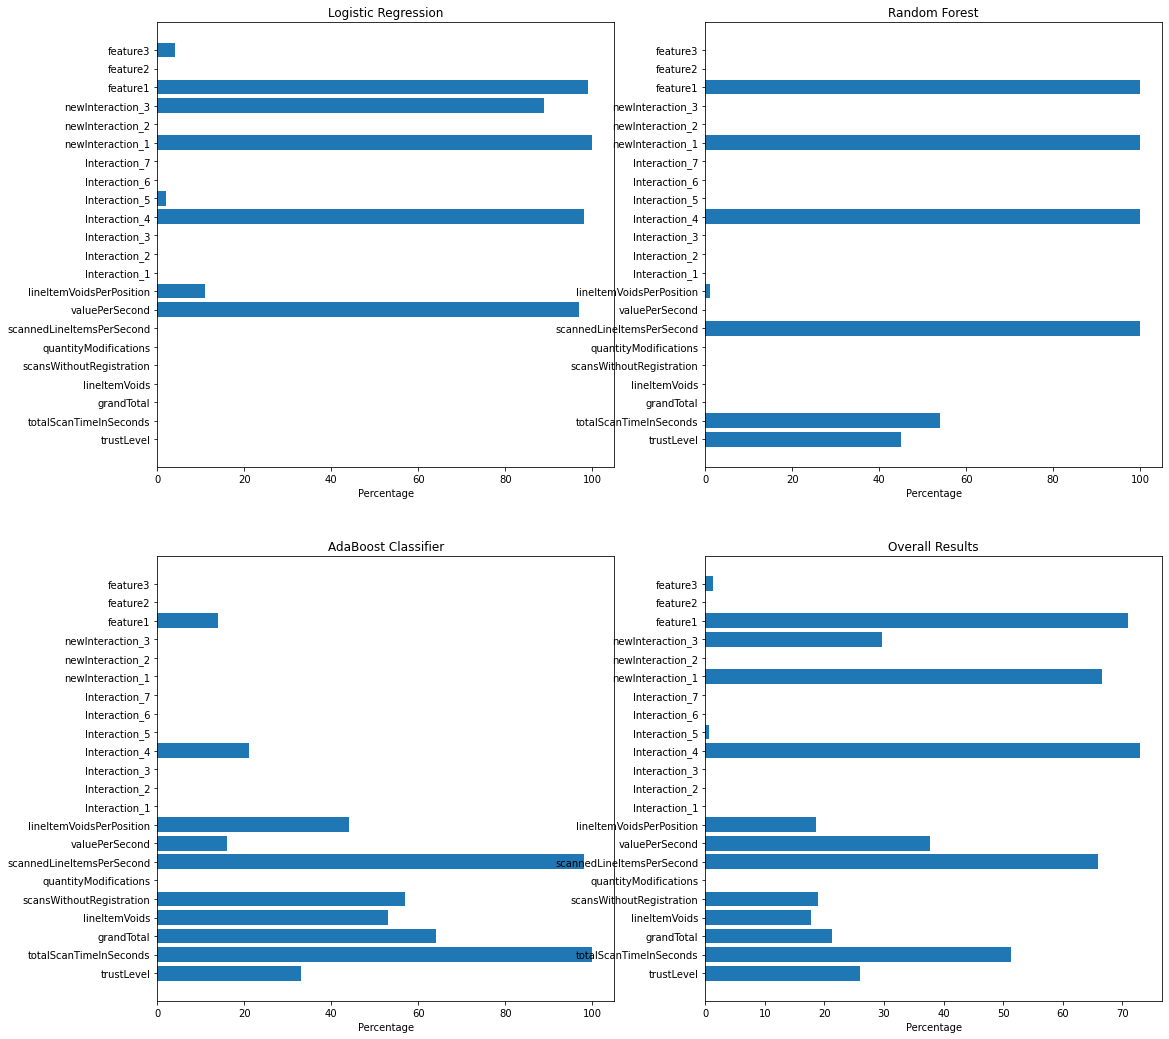

In [39]:
#Graphing results after 2 hours of figuring out how to do these stupid graphs 
fig, axes = plt.subplots(2, 2, figsize = (18, 18))
#Logistic Regression
axes[0, 0].barh(LR1.index, LR1.values)
axes[0, 0].set_xlabel('Percentage')
axes[0, 0].set_title('Logistic Regression')
#Random Forrest
axes[0, 1].barh(RF1.index, RF1.values)
axes[0, 1].set_xlabel('Percentage')
axes[0, 1].set_title('Random Forest')
#Ada Boost
axes[1, 0].barh(Ada1.index, Ada1.values)
axes[1, 0].set_xlabel('Percentage')
axes[1, 0].set_title('AdaBoost Classifier')
#Overall Results
axes[1, 1].barh(results.index, results.values)
axes[1, 1].set_xlabel('Percentage')
axes[1, 1].set_title('Overall Results')

In [ ]:
#Based on the above graphs the 5 variables that have the most importance are 

#1 Interaction 4
#2 Feature1
#3 NewInteraction_1
#4 scannedLineItemsPerSecond
#5 totalScanTimeInSeconds